# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this link: [https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312]. Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following link: [https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ]. 

# Step 1: Problem formulation and data collection

Start this project off by writing a few sentences below that summarize the business problem and the business goal you're trying to achieve in this scenario. Include a business metric you would like your team to aspire toward. With that information defined, clearly write out the machine learning problem statement. Finally, add a comment or two about the type of machine learning this represents. 


### 1. Determine if and why ML is an appropriate solution to deploy.

Machine learning fits for this task at least for two reasons: 
1. it is ready to process huge volumes of historical flight data effectively for delivering delay forecasts and can be very effective in finding patterns and dependencies in data, such as the relations of weather conditions and flight delays. 
2. We can automatically predict, using ML in this task, the process will be much more reliable and speedy when compared to manual analyses. 

### 2. Formulate the business problem, success metrics, and desired ML output.

1. It is a business problem wherein prediction of possible flight delays due to weather conditions should drive improvement in customer satisfaction. In this manner, passengers will have full capability to plan their travel accordingly, hence avoiding the possible inconvenience of unexpected delays. 
2. Success will come with the accuracy of the predictions; that is, the higher your accuracy, the more reliable your predictions. The desired result from the ML model output is a binary indicator that should take values of 0 or 1, representing delay and no delay, respectively.

### 3. Identify the type of ML problem you’re dealing with.

This is a classification problem whereby the ML model has to label each flight whether it is delayed, which will be represented as '1', or not delayed, represented as '0' with input features like the weather condition, time of departure, airline among others. Such problems are ideal for supervised learning whereby the model is trained on historic data whose end result or target variable is known.

### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

In [421]:
#!pip install pathlib2

import os
from pathlib2 import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

Start by bringing in the dataset from an Amazon S3 public bucket to this notebook environment.

In [422]:
# download the files

# <note: make them all relative, absolute path is not accepted>
zip_path = 'data/OneDrive_1_2024-10-19'
base_path = 'Final_Project'
csv_base_path = 'csv_files'

!mkdir -p {csv_base_path}

In [423]:
# How many zip files do we have? write a code to answer it.
zip_path = 'data/OneDrive_1_2024-10-19'
files_in_directory = os.listdir(zip_path)
zip_files_count = 0
for file in files_in_directory:
    if file.endswith('.zip'):
        zip_files_count += 1
        
print(f'The number of zip files is {zip_files_count}')

The number of zip files is 60


#### Extract CSV files from ZIP files

In [424]:
Extract CSV files from ZIP files 
def zip2csv(zipFile_name , file_path):
    """
    Extract csv from zip files
    zipFile_name: name of the zip file
    file_path : name of the folder to store csv
    """

    try:
        with ZipFile(zipFile_name, 'r') as z: 
            print(f'Extracting {zipFile_name} ') 
            z.extractall(path=file_path)
    except:
        print(f'zip2csv failed for {zipFile_name}')
        
zip_files = [os.path.join(zip_path, f) for f in os.listdir(zip_path) if f.endswith('.zip')]

for file in zip_files:
    zip2csv(file, csv_base_path)

print("Files Extracted")

In [425]:
# How many csv files have we extracted? write a code to answer it.
csv_path = 'csv_files'
csv_files_in_directory = os.listdir(csv_path)
csv_files_count = 0
for file in csv_files_in_directory:
    if file.endswith('.csv'):
        csv_files_count += 1
        
print(f'The number of csv files is {csv_files_count}')

The number of csv files is 60


Before loading the CSV file, read the HTML file from the extracted folder. This HTML file includes the background and more information on the features included in the dataset.

In [426]:
from IPython.display import IFrame

IFrame(src=os.path.relpath(f"{csv_base_path}readme.html"), width=1000, height=600)

#### Load sample CSV

Before combining all the CSV files, get a sense of the data from a single CSV file. Using Pandas, read the `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` file first. You can use the Python built-in `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [427]:
df_temp = pd.read_csv("csv_files/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv")

**Question**: Print the row and column length in the dataset, and print the column names.

In [428]:
df_shape = df_temp.shape # **ENTER YOUR CODE HERE**
print(f'Rows and columns in one csv file is {df_shape}')

Rows and columns in one csv file is (585749, 110)


**Question**: Print the first 10 rows of the dataset.  

In [429]:
# Enter your code here
df_temp.head(10)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2018,3,9,3,1,2018-09-03,9E,20363,9E,N908XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,3,9,9,7,2018-09-09,9E,20363,9E,N315PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,3,9,10,1,2018-09-10,9E,20363,9E,N582CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,3,9,13,4,2018-09-13,9E,20363,9E,N292PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,3,9,14,5,2018-09-14,9E,20363,9E,N600LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018,3,9,16,7,2018-09-16,9E,20363,9E,N316PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018,3,9,17,1,2018-09-17,9E,20363,9E,N916XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018,3,9,20,4,2018-09-20,9E,20363,9E,N371CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018,3,9,21,5,2018-09-21,9E,20363,9E,N601LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018,3,9,23,7,2018-09-23,9E,20363,9E,N906XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Question**: Print all the columns in the dataset. Use `<dataframe>.columns` to view the column names.

In [430]:
print(f'The column names are :')
print('#########')
for col in df_temp.columns:# **ENTER YOUR CODE HERE**
    print(col)

The column names are :
#########
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Div1

**Question**: Print all the columns in the dataset that contain the word 'Del'. This will help you see how many columns have delay data in them.

**Hint**: You can use a Python list comprehension to include values that pass certain `if` statement criteria.

For example: `[x for x in [1,2,3,4,5] if x > 2]`  

**Hint**: You can use the `in` keyword ([documentation](https://www.w3schools.com/python/ref_keyword_in.asp)) to check if the value is in a list or not. 

For example: `5 in [1,2,3,4,5]`

In [431]:
# Enter your code here
columns_with_del = [col for col in df_temp.columns if 'Del' in col]
print("columns in the dataset that contain the word 'Del' are ", columns_with_del)

columns in the dataset that contain the word 'Del' are  ['DepDelay', 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'DivArrDelay']


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [432]:
# to answer above questions, complete the following code
print("The #rows and #columns are ", df_temp.shape[0] , " and ", df_temp.shape[1])
print("The years in this dataset are: ", df_temp['Year'].unique())
print("The months covered in this dataset are: ", df_temp['Month'].unique())
print("The date range for data is :" , min(df_temp['FlightDate']), " to ", max(df_temp['FlightDate']))
print("The airlines covered in this dataset are: ", list(df_temp['Reporting_Airline'].unique()))
print("The Origin airports covered are: ", list(df_temp['Origin'].unique()))
print("The Destination airports covered are: ", list(df_temp['Dest'].unique()))

The #rows and #columns are  585749  and  110
The years in this dataset are:  [2018]
The months covered in this dataset are:  [9]
The date range for data is : 2018-09-01  to  2018-09-30
The airlines covered in this dataset are:  ['9E', 'B6', 'WN', 'YV', 'YX', 'EV', 'AA', 'AS', 'DL', 'HA', 'UA', 'F9', 'G4', 'MQ', 'NK', 'OH', 'OO']
The Origin airports covered are:  ['DFW', 'LGA', 'MSN', 'MSP', 'ATL', 'BDL', 'VLD', 'JFK', 'RDU', 'CHS', 'DTW', 'GRB', 'PVD', 'SHV', 'FNT', 'PIT', 'RIC', 'RST', 'RSW', 'CVG', 'LIT', 'ORD', 'JAX', 'TRI', 'BOS', 'CWA', 'DCA', 'CHO', 'AVP', 'IND', 'GRR', 'BTR', 'MEM', 'TUL', 'CLE', 'STL', 'BTV', 'OMA', 'MGM', 'TVC', 'SAV', 'GSP', 'EWR', 'OAJ', 'BNA', 'MCI', 'TLH', 'ROC', 'LEX', 'PWM', 'BUF', 'AGS', 'CLT', 'GSO', 'BWI', 'SAT', 'PHL', 'TYS', 'ACK', 'DSM', 'GNV', 'AVL', 'BGR', 'MHT', 'ILM', 'MOT', 'IAH', 'SBN', 'SYR', 'ORF', 'MKE', 'XNA', 'MSY', 'PBI', 'ABE', 'HPN', 'EVV', 'ALB', 'LNK', 'AUS', 'PHF', 'CHA', 'GTR', 'BMI', 'BQK', 'CID', 'CAK', 'ATW', 'ABY', 'CAE', 'SRQ

**Question**: What is the count of all the origin and destination airports?

**Hint**: You can use the Pandas `values_count` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)) to find out the values for each airport using the columns `Origin` and `Dest`.

In [433]:
counts = pd.DataFrame({'Origin':df_temp['Origin'].value_counts(), 'Destination':df_temp['Dest'].value_counts()})
counts

,Origin,Destination
ABE,303,303
ABI,169,169
ABQ,2077,2076
ABR,60,60
ABY,79,79
...,...,...
WRG,60,60
WYS,52,52
XNA,1004,1004
YAK,60,60


**Question**: Print the top 15 origin and destination airports based on number of flights in the dataset.

**Hint**: You can use the Pandas `sort_values` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)).

In [434]:
counts.sort_values(by="Origin",ascending=False).head(15) # Enter your code here

,Origin,Destination
ATL,31525,31521
ORD,28257,28250
DFW,22802,22795
DEN,19807,19807
CLT,19655,19654
LAX,17875,17873
SFO,14332,14348
IAH,14210,14203
LGA,13850,13850
MSP,13349,13347


**Question**: Given all the information about a flight trip, can you predict if it would be delayed?

### Enter your answer here
Yes, with the appropriate features and data, I can predict if a flight will be delayed. By using machine learning models trained on historical flight data, such as departure times, airlines, distances, and previous delays, I can assess the likelihood of future delays for flights. This approach enables more informed decision-making for managing travel plans and expectations. The prediction should involve these basic steps:
1. Data Preparation: Filter data and select relevant features like date, time, airline, distance, and delay history.
2. Feature Engineering: Convert categorical data to numerical formats and create time-related features if necessary.
3. Model Selection: Choose a suitable predictive model like logistic regression or a decision tree.
4. Training and Evaluation: Split the data into training and testing sets, train the model, and evaluate its performance using the test set.
5. Deployment: Implement the model to predict and inform about potential delays.

Now, assume you are traveling from San Francisco to Los Angeles on a work trip. You want to have an ideas if your flight will be delayed, given a set of features, so that you can manage your reservations in Los Angeles better. How many features from this dataset would you know before your flight?

Columns such as `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, and `DivArrDelay` contain information about a delay. But this delay could have occured at the origin or destination. If there were a sudden weather delay 10 minutes before landing, this data would not be helpful in managing your Los Angeles reservations.

So to simplify the problem statement, consider the following columns to predict an arrival delay:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

You will also filter the source and destination airports to be:
- Top airports: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Top 5 airlines: UA, OO, WN, AA, DL

This should help in reducing the size of data across the CSV files to be combined.

#### Combine all CSV files

**Hint**:  
First, create an empy dataframe that you will use to copy your individual dataframes from each file. Then, for each file in the `csv_files` list:

1. Read the CSV file into a dataframe  
2. Filter the columns based on the `filter_cols` variable

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Keep only the subset_vals in each of the subset_cols. Use the `isin` Pandas function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)) to check if the `val` is in the dataframe column and then choose the rows that include it.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatenate the dataframe with the empty dataframe 

In [435]:
def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name):
    """
    Combine csv files into one Data Frame
    csv_files: list of csv file paths
    filter_cols: list of columns to filter
    subset_cols: list of columns to subset rows
    subset_vals: list of list of values to subset rows
    """
    # Create an empty dataframe    
    combined_df = pd.DataFrame() # Enter your code here 
    
    #<complete the code of this function>
    # Loop through each CSV file
    for csv_file in csv_files:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_file, usecols=filter_cols)
        
        # Apply subsetting based on subset values in subset columns
        for col, vals in zip(subset_cols, subset_vals):
            df = df[df[col].isin(vals)]
        
        # Concatenate the individual DataFrame into the combined DataFrame
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    # Save the combined DataFrame to a CSV file
    combined_df.to_csv(file_name, index=False)
    
    return combined_df

In [436]:
#cols is the list of columns to predict Arrival Delay 
cols = ['Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
        'Reporting_Airline','Origin','OriginState','Dest','DestState',
        'CRSDepTime','Cancelled','Diverted','Distance','DistanceGroup',
        'ArrDelay','ArrDelayMinutes','ArrDel15','AirTime']

subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# subset_vals is a list collection of the top origin and destination airports and top 5 airlines
subset_vals = [['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['UA', 'OO', 'WN', 'AA', 'DL']]

csv_files = [os.path.join(csv_base_path, f) for f in os.listdir(csv_base_path) if f.endswith('.csv')]

Use the function above to merge all the different files into a single file that you can read easily. 

**Note**: This will take 5-7 minutes to complete.

In [437]:
start = time.time()

combined_csv_filename = f"{base_path}combined_files.csv"

# < write code to call the combined_csv function>
combine_csv(
    csv_files, 
    cols,
    subset_cols,
    subset_vals,
    combined_csv_filename
)

print(f'csv\'s merged in {round((time.time() - start)/60,2)} minutes')

csv's merged in 1.39 minutes


#### Load dataset

Load the combined dataset.

In [438]:
data = pd.read_csv(combined_csv_filename)# Enter your code here to read the combined csv file.

Print the first 5 records.

In [439]:
# Enter your code here 
data.head(5)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,DestState,CRSDepTime,ArrDelay,ArrDelayMinutes,ArrDel15,Cancelled,Diverted,AirTime,Distance,DistanceGroup
0,2014,1,1,26,7,2014-01-26,DL,ATL,GA,IAH,TX,2145,-20.0,0.0,0.0,0.0,0.0,99.0,689.0,3
1,2014,1,1,26,7,2014-01-26,DL,DFW,TX,ATL,GA,945,-3.0,0.0,0.0,0.0,0.0,98.0,731.0,3
2,2014,1,1,26,7,2014-01-26,DL,ATL,GA,DEN,CO,1855,-7.0,0.0,0.0,0.0,0.0,174.0,1199.0,5
3,2014,1,1,26,7,2014-01-26,DL,ATL,GA,PHX,AZ,1634,-4.0,0.0,0.0,0.0,0.0,233.0,1587.0,7
4,2014,1,1,26,7,2014-01-26,DL,PHX,AZ,ATL,GA,700,-13.0,0.0,0.0,0.0,0.0,179.0,1587.0,7


Here are some more questions to help you find out more about your dataset.

**Questions**   
1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [440]:
# to answer above questions, complete the following code
print("The #rows and #columns are ", data.shape[0] , " and ", data.shape[1])
print("The years in this dataset are: ", list(data['Year'].unique()))
print("The months covered in this dataset are: ", sorted(list(data['Month'].unique())))
print("The date range for data is :" , min(data['FlightDate']), " to ", max(data['FlightDate']))
print("The airlines covered in this dataset are: ", list(data['Reporting_Airline'].unique()))
print("The Origin airports covered are: ", list(data['Origin'].unique()))
print("The Destination airports covered are: ", list(data['Dest'].unique()))

The #rows and #columns are  1658130  and  20
The years in this dataset are:  [2014, 2015, 2016, 2017, 2018]
The months covered in this dataset are:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
The date range for data is : 2014-01-01  to  2018-12-31
The airlines covered in this dataset are:  ['DL', 'OO', 'WN', 'UA', 'AA']
The Origin airports covered are:  ['ATL', 'DFW', 'PHX', 'DEN', 'IAH', 'CLT', 'SFO', 'LAX', 'ORD']
The Destination airports covered are:  ['IAH', 'ATL', 'DEN', 'PHX', 'CLT', 'LAX', 'DFW', 'SFO', 'ORD']


Let's define our **target column : is_delay** (1 - if arrival time delayed more than 15 minutes, 0 - otherwise). Use the `rename` method to rename the column from `ArrDel15` to `is_delay`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

For example:
```
df.rename(columns={'col1':'column1'}, inplace=True)
```

In [441]:
data.rename(columns={'ArrDel15':'is_delay'}, inplace=True) # Enter your code here

Look for nulls across columns. You can use the `isnull()` function ([documentation](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)).

**Hint**: `isnull()` detects whether the particular value is null or not and gives you a boolean (True or False) in its place. Use the `sum(axis=0)` function to sum up the number of columns.

In [442]:
# Enter your code here
data.isnull().sum(axis=0)

Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
FlightDate               0
Reporting_Airline        0
Origin                   0
OriginState              0
Dest                     0
DestState                0
CRSDepTime               0
ArrDelay             22540
ArrDelayMinutes      22540
is_delay             22540
Cancelled                0
Diverted                 0
AirTime              22540
Distance                 0
DistanceGroup            0
dtype: int64

The arrival delay details and airtime are missing for 22540 out of 1658130 rows, which is 1.3%. You can either remove or impute these rows. The documentation does not mention anything about missing rows.

**Hint**: Use the `~` operator to choose the values that aren't null from the `isnull()` output.

For example:
```
null_eg = df_eg[~df_eg['column_name'].isnull()]
```

In [443]:
### Remove null columns
data = data[ # Enter your code here
    ~data['ArrDelay'].isnull() & 
    ~data['ArrDelayMinutes'].isnull() & 
    ~data['is_delay'].isnull() & 
    ~data['AirTime'].isnull()
]
data

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,DestState,CRSDepTime,ArrDelay,ArrDelayMinutes,is_delay,Cancelled,Diverted,AirTime,Distance,DistanceGroup
0,2014,1,1,26,7,2014-01-26,DL,ATL,GA,IAH,TX,2145,-20.0,0.0,0.0,0.0,0.0,99.0,689.0,3
1,2014,1,1,26,7,2014-01-26,DL,DFW,TX,ATL,GA,945,-3.0,0.0,0.0,0.0,0.0,98.0,731.0,3
2,2014,1,1,26,7,2014-01-26,DL,ATL,GA,DEN,CO,1855,-7.0,0.0,0.0,0.0,0.0,174.0,1199.0,5
3,2014,1,1,26,7,2014-01-26,DL,ATL,GA,PHX,AZ,1634,-4.0,0.0,0.0,0.0,0.0,233.0,1587.0,7
4,2014,1,1,26,7,2014-01-26,DL,PHX,AZ,ATL,GA,700,-13.0,0.0,0.0,0.0,0.0,179.0,1587.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658125,2018,3,9,11,2,2018-09-11,WN,DEN,CO,PHX,AZ,1105,-18.0,0.0,0.0,0.0,0.0,87.0,602.0,3
1658126,2018,3,9,11,2,2018-09-11,WN,DEN,CO,SFO,CA,825,-8.0,0.0,0.0,0.0,0.0,133.0,967.0,4
1658127,2018,3,9,11,2,2018-09-11,WN,DEN,CO,SFO,CA,1240,17.0,17.0,1.0,0.0,0.0,141.0,967.0,4
1658128,2018,3,9,11,2,2018-09-11,WN,DEN,CO,SFO,CA,2210,2.0,2.0,0.0,0.0,0.0,138.0,967.0,4


In [444]:
data.isnull().sum(axis=0)

Year                 0
Quarter              0
Month                0
DayofMonth           0
DayOfWeek            0
FlightDate           0
Reporting_Airline    0
Origin               0
OriginState          0
Dest                 0
DestState            0
CRSDepTime           0
ArrDelay             0
ArrDelayMinutes      0
is_delay             0
Cancelled            0
Diverted             0
AirTime              0
Distance             0
DistanceGroup        0
dtype: int64

Get the hour of the day in 24-hour time format from CRSDepTime.

In [445]:
data['DepHourofDay'] = data['CRSDepTime'].astype(str).str.zfill(4).str[:2] # Enter your code here

## **The ML problem statement**
- Given a set of features, can you predict if a flight is going to be delayed more than 15 minutes?
- Because the target variable takes only 0/1 value, you could use a classification algorithm. 

### Data exploration

#### Check class delay vs. no delay

**Hint**: Use a `groupby` plot ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)) with a `bar` plot ([documentation](https://matplotlib.org/tutorials/introductory/pyplot.html)) to plot the frequency vs. distribution of the class.

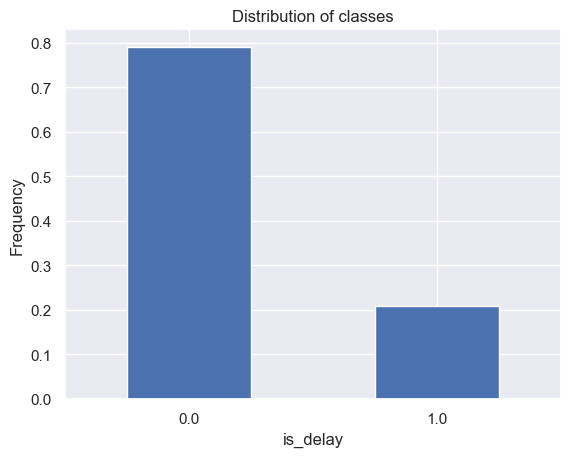

In [446]:
(data.groupby('is_delay').size()/len(data) ).plot(kind='bar')# Enter your code here
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.xticks(rotation=0)
plt.show()

**Question**: What can you deduce from the bar plot about the ratio of delay vs. no delay?

The bar plot shows the distribution of flights according to their delay status, where '0' denotes no delay and '1' denotes a delay. From this plot, we can further infer that most flights are not delayed, label 0.0, simply because the height of the bar is much taller compared with the bar for delayed flights, label 1.0. This would mean that, in the dataset, delays are less frequent and most flights tend to be on time or within the accepted delay threshold of less than 15 minutes. The exact values indicate that about 80% experience no delay when about 20% of the flights are considered to be delayed by more than 15 minutes. This information is useful in predicting flight delays and can set expectations for travel planning and management.# Enter your answer here and turn the cell type to markdown

**Questions**: 

- Which months have the most delays?
- What time of the day has the most delays?
- What day of the week has the most delays?
- Which airline has the most delays?
- Which origin and destination airports have the most delays?
- Is flight distance a factor in the delays?

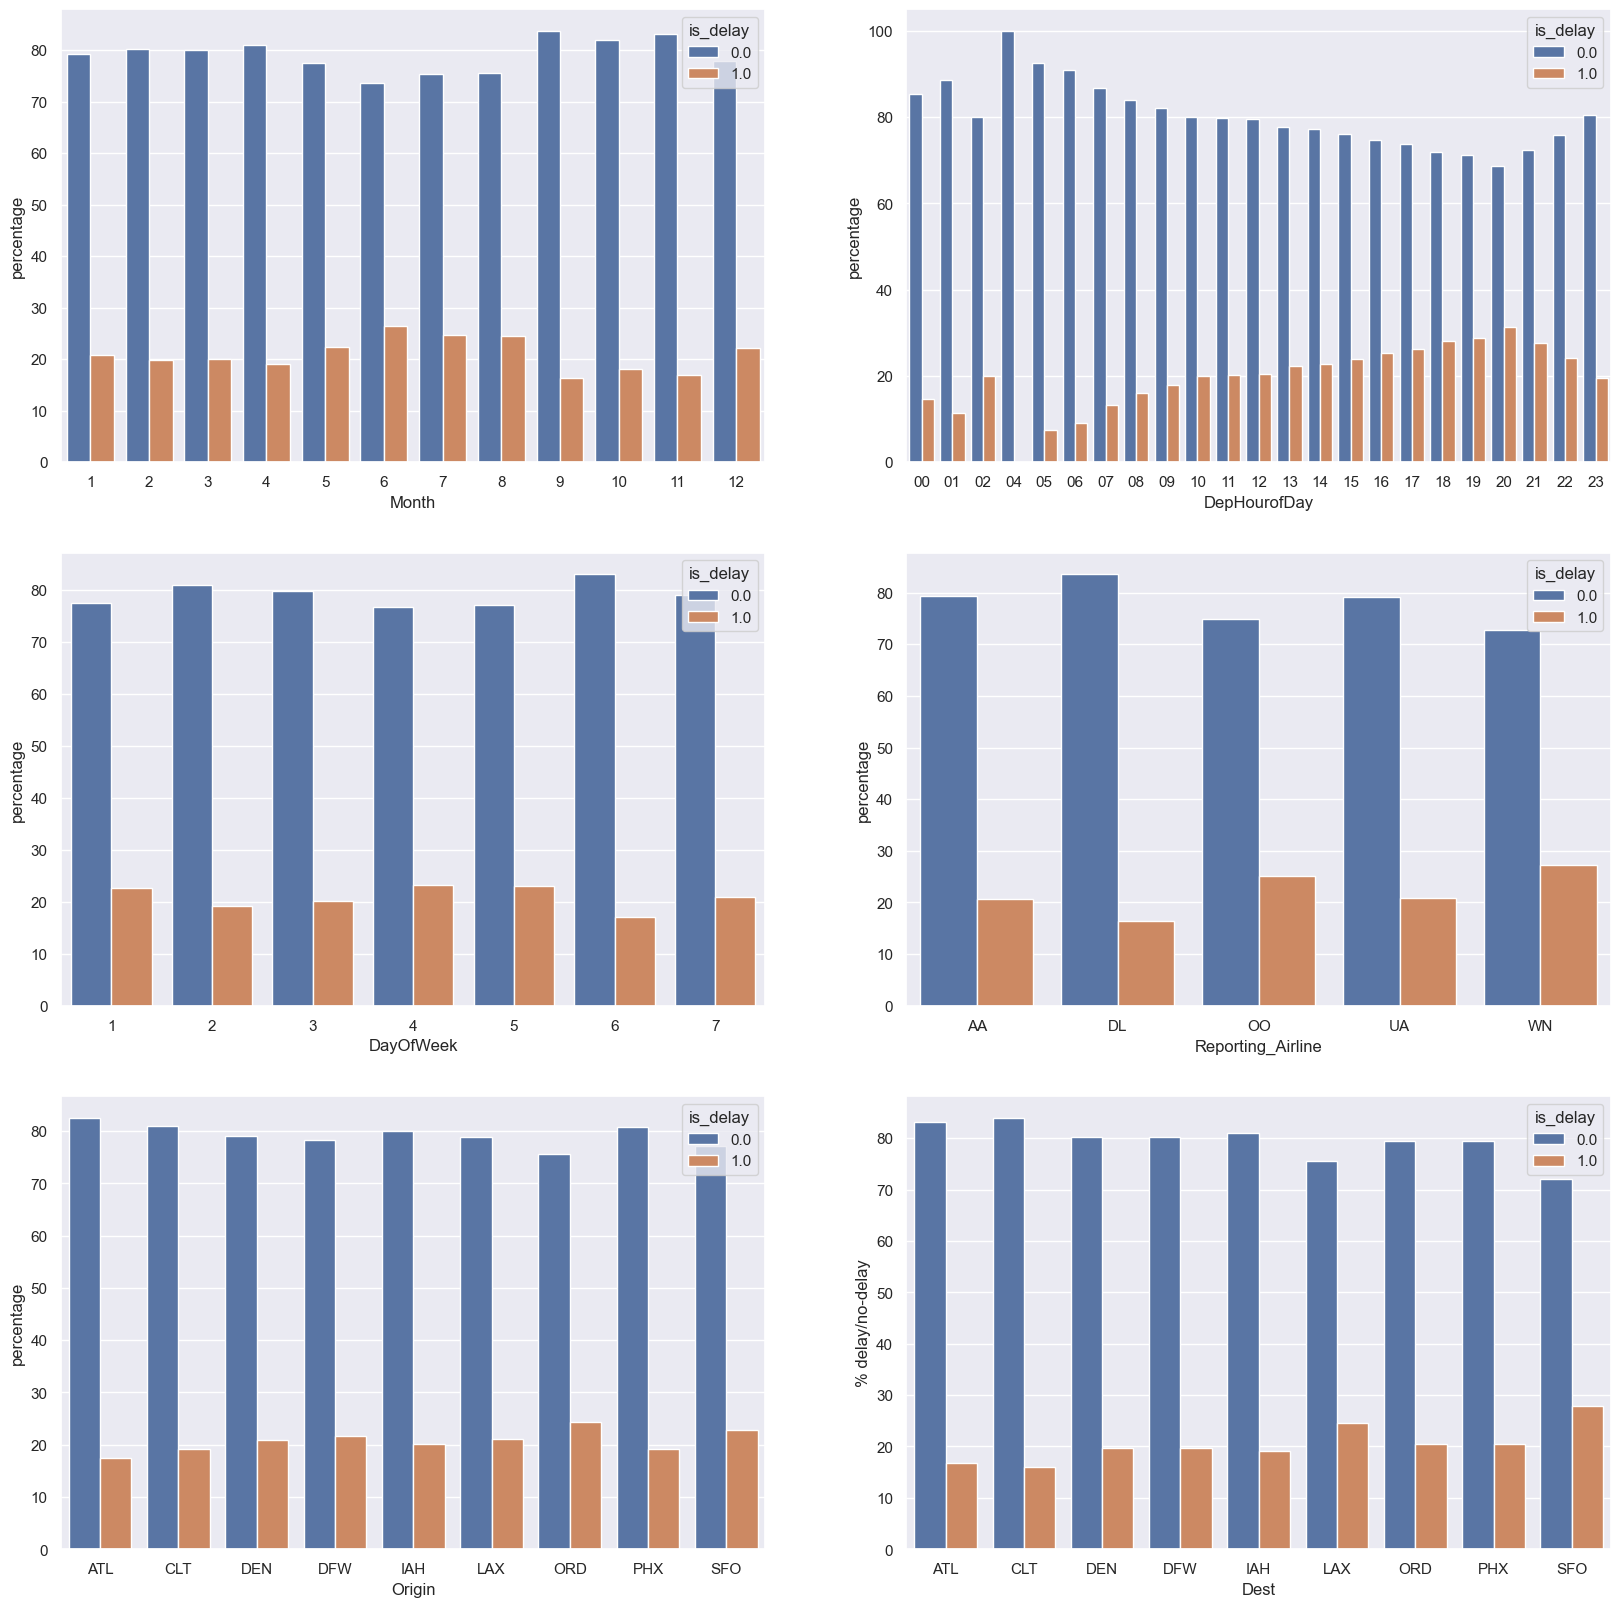

In [447]:
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20,20), squeeze=False)
# fig.autofmt_xdate(rotation=90)

for idx, column in enumerate(viz_columns):
    ax = axes[idx//2, idx%2]
    temp = data.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage').\
    mul(100).reset_index().sort_values(column)
    sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax)
    plt.ylabel('% delay/no-delay')

plt.show()

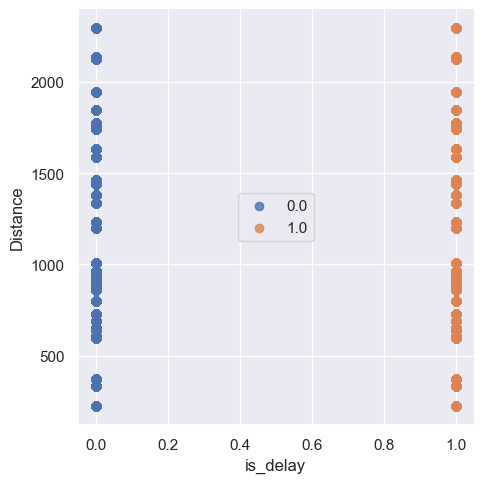

In [448]:
sns.lmplot( x="is_delay", y="Distance", data=data, fit_reg=False, hue='is_delay', legend=False)
plt.legend(loc='center')
plt.xlabel('is_delay')
plt.ylabel('Distance')
plt.show()

**Answers**
- June (Month 6) shows highest instance of delays compared to other months.
- The late afternoon 20:00 (8 PM) of the day has the most delays.
- Thursday (Day 4) exhibits the highest percentage of delays compared to other days. 
- WN shows the highest proportion of delays among the airlines represented.
- Chicago O'Hare International Airport (ORD) show the highest percentage of delays among the origin airports displayed.
- It does not show a clear trend that longer distances are associated with more delays. Delays occur at all flight distances.

### Features

Look at all the columns and what their specific types are.

In [449]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'Cancelled',
       'Diverted', 'AirTime', 'Distance', 'DistanceGroup', 'DepHourofDay'],
      dtype='object')

In [450]:
data.dtypes

Year                   int64
Quarter                int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
FlightDate            object
Reporting_Airline     object
Origin                object
OriginState           object
Dest                  object
DestState             object
CRSDepTime             int64
ArrDelay             float64
ArrDelayMinutes      float64
is_delay             float64
Cancelled            float64
Diverted             float64
AirTime              float64
Distance             float64
DistanceGroup          int64
DepHourofDay          object
dtype: object

Filtering the required columns:
- Date is redundant, because you have Year, Quarter, Month, DayofMonth, and DayOfWeek to describe the date.
- Use Origin and Dest codes instead of OriginState and DestState.
- Because you are just classifying whether the flight is delayed or not, you don't need TotalDelayMinutes, DepDelayMinutes, and ArrDelayMinutes.

Treat DepHourofDay as a categorical variable because it doesn't have any quantitative relation with the target.
- If you had to do a one-hot encoding of it, it would result in 23 more columns.
- Other alternatives to handling categorical variables include hash encoding, regularized mean encoding, and bucketizing the values, among others.
- Just split into buckets here.

**Hint**: To change a column type to category, use the `astype` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)).

In [451]:
data_orig = data.copy()
data = data[[ 'is_delay', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay']] 
categorical_columns  = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay']
for c in categorical_columns:
    data[c] = data[c].astype('category') # Enter your code here
    
# Ensure DepHourofDay is in integer format
data['DepHourofDay'] = data['DepHourofDay'].astype(int)

# Define the boundaries and labels for the buckets
bins = [0, 6, 12, 18, 24] 
labels = ['Night', 'Morning', 'Afternoon', 'Evening']

# Bucket the DepHourofDay into parts of the day
data['DepHourofDay'] = pd.cut(data['DepHourofDay'], bins=bins, labels=labels, include_lowest=True)

# Convert the newly bucketed column to categorical type
data['DepHourofDay'] = data['DepHourofDay'].astype('category')

To use one-hot encoding, use the Pandas `get_dummies` function for the categorical columns that you selected above. Then, you can concatenate those generated features to your original dataset using the Pandas `concat` function. For encoding categorical variables, you can also use *dummy encoding* by using a keyword `drop_first=True`. For more information on dummy encoding, see https://en.wikiversity.org/wiki/Dummy_variable_(statistics).

For example:
```
pd.get_dummies(df[['column1','columns2']], drop_first=True)
```

In [452]:
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True) # Enter your code here
data = pd.concat([data, data_dummies], axis = 1)
data.drop(categorical_columns,axis=1, inplace=True)


Check the length of the dataset and the new columnms.

In [453]:
# Enter your code here
print("Number of rows in the dataset:", len(data))

Number of rows in the dataset: 1635590


In [454]:
# Enter your code here
print("Columns in the dataset: \n", data.columns)

Columns in the dataset: 
 Index(['is_delay', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', '

**Sample Answer:** 
```
Index(['Distance', 'is_delay', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO'],
      dtype='object')
```

Now you are ready to do model training. Before splitting the data, rename the column `is_delay` to `target`.

**Hint**: You can use the Pandas `rename` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

In [455]:
data.rename(columns = {'is_delay':"target"}, inplace=True )

In [456]:
# write code to Save the combined csv file (combined_csv_v1.csv) to your local computer
# note this combined file will be used in part B
data.to_csv('combined_csv_v1.csv', index=False)

In [457]:
data.columns

Index(['target', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_9', 'Month_10', 'Month_11', 'Month_12', 'DayofMonth_2',
       'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5', 'DayofMonth_6',
       'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9', 'DayofMonth_10',
       'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13', 'DayofMonth_14',
       'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17', 'DayofMonth_18',
       'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21', 'DayofMonth_22',
       'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25', 'DayofMonth_26',
       'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29', 'DayofMonth_30',
       'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
       'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'Reporting_Airline_DL',
       'Reporting_Airline_OO', 'Reporting_Airline_UA', 'Reporting_Airline_WN',
       'Origin_CLT', 'Origin_DEN', '

# Step 3: Model training and evaluation

1. Split the data into `train_data`, and `test_data` using `sklearn.model_selection.train_test_split`.  
2. Build a logistic regression model for the data, where training data is 80%, and test data is 20%.

Use the following cells to complete these steps. Insert and delete cells where needed.


### Train test split

In [458]:
# write Code here to split data into train, validate and test
# split data into train, validate and test
X = data.drop('target', axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

### Baseline classification model

In [459]:
# Create a logistic regression model
logreg = LogisticRegression()

# Fit model
logreg.fit(X_train, y_train)

# Predicting on the training data to see baseline performance
y_pred = logreg.predict(X_test)

## Model evaluation
In this section, you'll evaluate your trained model on test data and report on the following metrics:
* Confusion Matrix plot
* Plot the ROC
* Report statistics such as Accuracy, Percision, Recall, Sensitivity and Specificity

To view a plot of the confusion matrix, and various scoring metrics, create a couple of functions:

In [460]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(test_labels, target_predicted):
  # complete the code here
   cm = confusion_matrix(test_labels, target_predicted)
       
 # Print confusion matrix and TP, TN, FP, FN
   print('Confusion matrix\n\n', cm)
   print('\nTrue Positives (TP) = ', cm[0, 0])
   print('\nTrue Negatives (TN) = ', cm[1, 1])
   print('\nFalse Positives (FP) = ', cm[0, 1])
   print('\nFalse Negatives (FN) = ', cm[1, 0])   
    
   sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
   plt.xlabel('Predicted Labels')
   plt.ylabel('True Labels')
   plt.title('Confusion Matrix')
   plt.show()

In [461]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt

def plot_roc(test_labels, target_predicted_prob):
    # complete the code here
    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

    # Annotate accuracy, precision, recall, and F1 score on the plot
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print metrics
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')

To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and `target_predicted` data from your batch job:

Confusion matrix

 [[258097    137]
 [ 68732    152]]

True Positives (TP) =  258097

True Negatives (TN) =  152

False Positives (FP) =  137

False Negatives (FN) =  68732


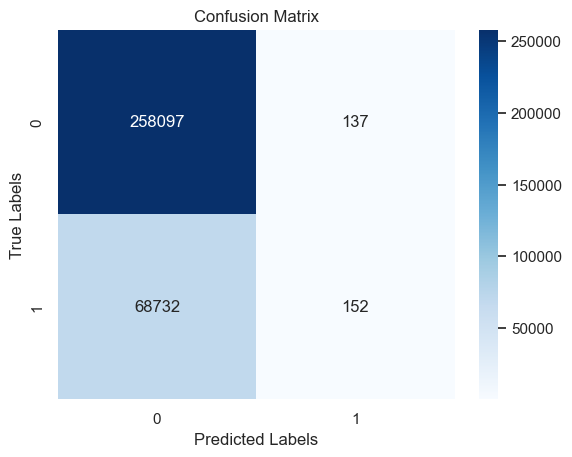

In [462]:
# Enter you code here
plot_confusion_matrix(y_test, y_pred)

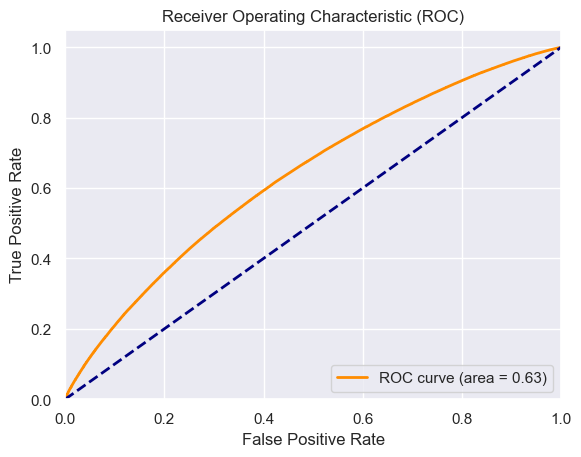

Accuracy: 0.79
Precision: 0.53
Recall: 0.00
F1 Score: 0.00


In [463]:
# generate ROC plot on training data
plot_roc(y_train, logreg.predict_proba(X_train)[:, 1])

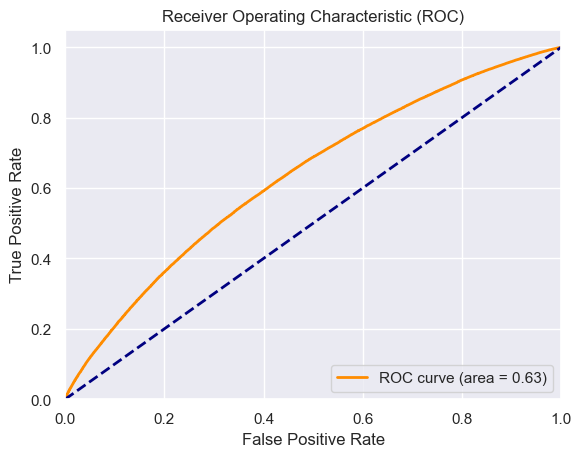

Accuracy: 0.79
Precision: 0.53
Recall: 0.00
F1 Score: 0.00


In [464]:
# generate ROC plot on test data
plot_roc(y_test, logreg.predict_proba(X_test)[:, 1])

### Key questions to consider :
    1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison?

    Its performance on the test set seems very close to that on the training set, giving a ROC AUC of 0.63. This means it generalizes pretty well, as there really does not appear to be any overfitting of the training data.


2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

    No significant differences in accuracy, precision, recall, and F1 score between the train and test sets; the metrics are exactly the same for both. This is further observed by the fact that the rate differences do not mean anything but a poor, stable performance of the model in identifying positive cases, as probably depicted by a zero recall and F1 score.


3. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

    The result in terms of key performance indicators is inadequate from a business point of view. It would be relevant in the next iteration to address class imbalance and probably bring in more relevant features or apply advanced feature engineering techniques in order to improve the model's capability for accurate flight delay predictions.


**Question**: What can you summarize from the confusion matrix?


From the confusion matrix, we summarize the following:

**True Negatives TN**: The model accurately predicted 258,097 flights that were actually not late (True Negative). This shows that the model identifies flights that are not late.

**False Positives FP**: The model predicted 137 flights incorrectly to be late, when they were actually on time ( False Positive). This indicates that only very few flights are identified as being late when actually they are on time.

**False Negatives FN**: The model was unable to predict 68,732 flights that actually turned out to be delayed-FN. This shows that a significant amount of delays were missed out, which can lead to less customer satisfaction.

**True Positives TP**: The model correctly predicted 152 flights to be delayed-TP. This is a pretty small number from the total flights that are actually delayed. This implies the model might not be good enough to predict flight delays.

**Overall Insights**:
It also has a high TN count, that is to say, it's highly accurate concerning the flights that are not delayed, meaning low variance.
However, sensitivity or recall for the model to identify the delayed flights is poor due to the high number of FNs.
Skewed distribution in this case suggests that though this dataset is balanced on certain aspects, the model is capturing poorly the instances of the flights tagged as delayed, which essentially forms the critical business area of interest for a flight delay prediction.

# Step 4: Deployment

1. In this step you are required to push your source code and requirements file to a GitLab repository without the data files. Please use the Git commands to complete this task
2- Create a “readme.md” markdown file that describes the code of this repository and how to run it and what the user would expect if got the code running.

In the cell below provide the link of the pushed repository on your GitLab account.


In [465]:
### Provide a link for your Gitlab repository here
https://github.com/MeizhiZhaoRachel/DSTS_Final_Project.git

# Iteration II

# Step 5: Feature engineering

You've now gone through one iteration of training and evaluating your model. Given that the outcome you reached for your model the first time probably wasn't sufficient for solving your business problem, what are some things you could change about your data to possibly improve model performance?

### Key questions to consider:
1. How might the balance of your two main classes (delay and no delay) impact model performance?
2. Do you have any features that are correlated?
3. Are there feature reduction techniques you could perform at this stage that might have a positive impact on model performance? 
4. Can you think of adding some more data/datasets?
4. After performing some feature engineering, how does your model performance compare to the first iteration?

Use the cells below to perform specific feature engineering techniques (per the questions above) that you think could improve your model performance. Insert and delete cells where needed.


Before you start, think about why the precision and recall are around 80% while the accuracy is 99%.

#### Add more features

1. Holidays
2. Weather

Because the list of holidays from 2014 to 2018 is known, you can create an indicator variable **is_holiday** to mark these.
The hypothesis is that airplane delays could be higher during holidays compared to the rest of the days. Add a boolean variable `is_holiday` that includes the holidays for the years 2014-2018.

In [466]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

# Convert the list of holidays strings to datatime format for comparison
data_orig['FlightDate'] = data_orig['FlightDate'].astype(str)

### Add indicator variable for holidays
data_orig['is_holiday'] = data_orig['FlightDate'].isin(holidays).astype(int)# Enter your code here

Weather data was fetched from https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31.
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

**Question**: Could bad weather due to rains, heavy winds, or snow lead to airplane delay? Let's check!

Download data from the link above and place it into the data folder


Import weather data prepared for the airport codes in our dataset. Use the stations and airports below for the analysis, and create a new column called `airport` that maps the weather station to the airport name.

In [467]:
weather = pd.read_csv("data/daily-summaries-2024-10-24T01-40-38.csv") # Enter your code here to read 'daily-summaries.csv' file
station = ['USW00023174','USW00012960','USW00003017','USW00094846',
           'USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

### Map weather stations to airport code
station_map = dict(zip(station, airports))  
weather['airport'] = weather['STATION'].map(station_map)

# print the weather data
print(weather[['STATION','airport']].head)

<bound method NDFrame.head of            STATION airport
0      USW00023174     LAX
1      USW00023174     LAX
2      USW00023174     LAX
3      USW00023174     LAX
4      USW00023174     LAX
...            ...     ...
16429  USW00013881     CLT
16430  USW00013881     CLT
16431  USW00013881     CLT
16432  USW00013881     CLT
16433  USW00013881     CLT

[16434 rows x 2 columns]>


Create another column called `MONTH` from the `DATE` column.

In [468]:
weather['MONTH'] = weather['DATE'].apply(lambda x: x.split('-')[1]) # Enter your code here 
weather.head()

,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,airport,MONTH
0,USW00023174,2014-01-01,16,0,NaN,NaN,131.0,178.0,78.0,LAX,01
1,USW00023174,2014-01-02,22,0,NaN,NaN,159.0,256.0,100.0,LAX,01
2,USW00023174,2014-01-03,17,0,NaN,NaN,140.0,178.0,83.0,LAX,01
3,USW00023174,2014-01-04,18,0,NaN,NaN,136.0,183.0,100.0,LAX,01
4,USW00023174,2014-01-05,18,0,NaN,NaN,151.0,244.0,83.0,LAX,01


### Sample output
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analyze and handle the `SNOW` and `SNWD` columns for missing values using `fillna()`. Use the `isna()` function to check the missing values for all the columns.

In [469]:
weather.SNOW.fillna(0, inplace=True)# Enter your code here
weather.SNWD.fillna(0, inplace=True)# Enter your code here
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG       62
TMAX       20
TMIN       20
airport     0
MONTH       0
dtype: int64

**Question**: Print the index of the rows that have missing values for TAVG, TMAX, TMIN.

**Hint**: Use the `isna()` function to find the rows that are missing, and then use the list on the idx variable to get the index.

In [470]:
idx = np.array([i for i in range(len(weather))])
TAVG_idx = idx[weather['TAVG'].isna()]  # Enter your code here
TMAX_idx = idx[weather['TMAX'].isna()]  # Enter your code here
TMIN_idx = idx[weather['TMIN'].isna()]  # Enter your code here
TAVG_idx

array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])

### Sample output

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

You can replace the missing TAVG, TMAX, and TMIN with the average value for a particular station/airport. Because the consecutive rows of TAVG_idx are missing, replacing with a previous value would not be possible. Instead, replace it with the mean. Use the `groupby` function to aggregate the variables with a mean value.

In [471]:
# grouping by 'STATION', to ensure that filling in missing values with the average temperature specific to that station
# the agg function is used to calculate the mean of the temperature columns
weather_impute = weather.groupby(['STATION', 'MONTH']).agg({'TAVG':'mean','TMAX':'mean', 'TMIN':'mean' }).reset_index()
weather_impute.head(2)

,STATION,MONTH,TAVG,TMAX,TMIN
0,USW00003017,01,-2.741935,74.000000,-69.858065
1,USW00003017,02,11.219858,88.553191,-65.035461


Merge the mean data with the weather data.

In [472]:
### get the yesterday's data
weather = pd.merge(weather, weather_impute,  how='left', left_on=['MONTH','STATION'], right_on = ['MONTH','STATION'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG', 
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX', 
                   'TMIN_x':'TMIN'})

Check for missing values again.

In [473]:
weather.TAVG[TAVG_idx] = weather.TAVG_AVG[TAVG_idx]
weather.TMAX[TMAX_idx] = weather.TMAX_AVG[TMAX_idx]
weather.TMIN[TMIN_idx] = weather.TMIN_AVG[TMIN_idx]
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG        0
TMAX        0
TMIN        0
airport     0
MONTH       0
TAVG_AVG    0
TMAX_AVG    0
TMIN_AVG    0
dtype: int64

Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset

In [474]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

In [475]:
weather.columns

Index(['DATE', 'AWND', 'PRCP', 'SNOW', 'TAVG', 'airport'], dtype='object')

Add the origin and destination weather conditions to the dataset.

In [476]:
### Add origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

**Note**: It is always a good practice to check nulls/NAs after joins.

In [477]:
sum(data.isna().any())

0

In [478]:
data_orig.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'Cancelled',
       'Diverted', 'AirTime', 'Distance', 'DistanceGroup', 'DepHourofDay',
       'is_holiday', 'AWND_O', 'PRCP_O', 'SNOW_O', 'TAVG_O', 'AWND_D',
       'PRCP_D', 'SNOW_D', 'TAVG_D'],
      dtype='object')

Convert the categorical data into numerical data using one-hot encoding.

In [479]:
data = data_orig.copy()
data = data[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]


categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday', 'DepHourofDay']
for c in categorical_columns:
    data[c] = data[c].astype('category')
    
# Ensure DepHourofDay is in integer format
data['DepHourofDay'] = data['DepHourofDay'].astype(int)

# Define the boundaries and labels for the buckets
bins = [0, 6, 12, 18, 24] 
labels = ['Night', 'Morning', 'Afternoon', 'Evening']

# Bucket the DepHourofDay into parts of the day
data['DepHourofDay'] = pd.cut(data['DepHourofDay'], bins=bins, labels=labels, include_lowest=True)

# Convert the newly bucketed column to categorical type
data['DepHourofDay'] = data['DepHourofDay'].astype('category')

data.head()

,is_delay,Year,Quarter,Month,DayofMonth,DayOfWeek,Reporting_Airline,Origin,Dest,Distance,DepHourofDay,is_holiday,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,SNOW_D
0,0.0,2014,1,1,26,7,DL,ATL,IAH,689.0,Evening,0,33,0,54.0,30,0,130.0,0.0,0.0
1,0.0,2014,1,1,26,7,DL,DFW,ATL,731.0,Morning,0,39,0,136.0,33,0,54.0,0.0,0.0
2,0.0,2014,1,1,26,7,DL,ATL,DEN,1199.0,Afternoon,0,33,0,54.0,77,0,68.0,0.0,0.0
3,0.0,2014,1,1,26,7,DL,ATL,PHX,1587.0,Afternoon,0,33,0,54.0,20,0,165.0,0.0,0.0
4,0.0,2014,1,1,26,7,DL,PHX,ATL,1587.0,Morning,0,20,0,165.0,33,0,54.0,0.0,0.0


In [480]:
data_dummies = pd.get_dummies(data[categorical_columns], drop_first=True) # Enter your code here
data = pd.concat([data, data_dummies], axis = 1)
#categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)

data.head()

,is_delay,Distance,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,SNOW_D,...,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,is_holiday_1,DepHourofDay_Morning,DepHourofDay_Afternoon,DepHourofDay_Evening
0,0.0,689.0,33,0,54.0,30,0,130.0,0.0,0.0,...,False,True,False,False,False,False,False,False,False,True
1,0.0,731.0,39,0,136.0,33,0,54.0,0.0,0.0,...,False,False,False,False,False,False,False,True,False,False
2,0.0,1199.0,33,0,54.0,77,0,68.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
3,0.0,1587.0,33,0,54.0,20,0,165.0,0.0,0.0,...,False,False,False,False,True,False,False,False,True,False
4,0.0,1587.0,20,0,165.0,33,0,54.0,0.0,0.0,...,False,False,False,False,False,False,False,True,False,False


### Sample code

```
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data = pd.concat([data, data_dummies], axis = 1)
categorical_columns.remove('is_delay')
data.drop(categorical_columns,axis=1, inplace=True)
```

Check the new columns.

In [481]:
data.columns

Index(['is_delay', 'Distance', 'AWND_O', 'PRCP_O', 'TAVG_O', 'AWND_D',
       'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015', 'Year_2016',
       'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOf

### Sample output

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Rename the `is_delay` column to `target` again. Use the same code as before.

In [482]:
data.rename(columns = {'is_delay':'target'}, inplace=True )

In [483]:
# write code to Save the new combined csv file (combined_csv_v2.csv) to your local computer
# note this combined file will be also used in part B
data.to_csv('combined_csv_v2.csv', index=False)

Create the training and testing sets again.

In [484]:
# split data into train, validate and test
X = data.drop('target', axis=1)  
y = data['target'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

### New baseline classifier

Now, see if these new features add any predictive power to the model.

In [485]:
# Instantiate another logistic regression model
classifier2 = LogisticRegression() # Enter your code here

# Fit model
classifier2.fit(X_train, y_train)

# Predicting on the training data to see baseline performance
y_pred = classifier2.predict(X_test)

Confusion matrix

 [[255402   2832]
 [ 65640   3244]]

True Positives (TP) =  255402

True Negatives (TN) =  3244

False Positives (FP) =  2832

False Negatives (FN) =  65640


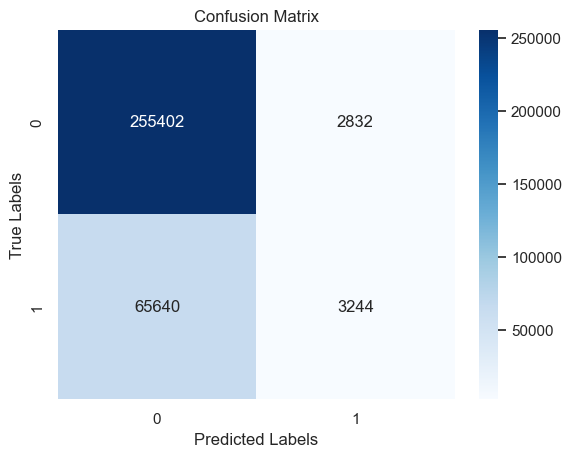

In [486]:
plot_confusion_matrix(y_test, y_pred)

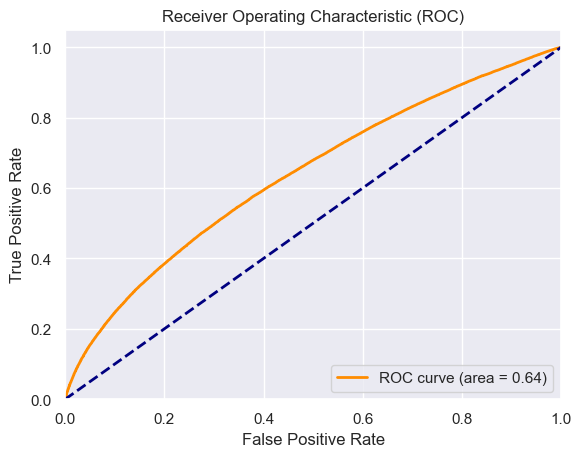

Accuracy: 0.79
Precision: 0.53
Recall: 0.05
F1 Score: 0.09


In [487]:
plot_roc(y_test, classifier2.predict_proba(X_test)[:, 1])

Perform the evaluaion as you have done with the previous model and plot/show the same metrics

Question: did you notice a difference by adding the extra data on the results?

Yes. Adding extra data the model led to a slight improvement in recall and F1 score, which suggests that the additional features contributed to better identification of delayed flights. However, the overall impact was modest, indicating that further adjustments or different types of data might be needed to significantly enhance model performance.

# Step 6: Using Tableau

Use Tableau to load the combined_csv_v2.csv file and build a dashboard that show your understanding of the data and business problem. 
### what to do:
1. Load the data into Tableau and build the dashboard
2. Share the dashboard on your Tableau public account 
3. Copy the link of the shared dashboard below

Note: The dashboard needs to be self explainable to others, so make it simple and add only the features that you feel heighlight the main question(s) of the prblem statement.

# copy the link here
https://public.tableau.com/app/profile/meizhi.zhao/viz/Final_Project_Tableau_17299302232300/DSTS_Final_Project?publish=yes

## Conclusion

You've now gone through at least a couple iterations of training and evaluating your model. It's time to wrap up this project and reflect on what you've learned and what types of steps you might take moving forward (assuming you had more time). Use the cell below to answer some of these and other relevant questions:

1. Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?
2. To what extent did your model improve as you made changes to your dataset? What types of techniques did you employ throughout this project that you felt yielded the greatest improvements in your model?
3. What were some of the biggest challenges you encountered throughout this project?
4. What were the three most important things you learned about machine learning while completing this project?

# write your answers here
1. Model Performance and Business Goals: My model performance has reached my business goal, which is to enable the ability to forecast delays flights are facing due to weather conditions. It actually provides huge insights for customers on how to travel in a better way and increases the quality of their experience.

2. Improved Based on Dataset Changes: There was some slight improvement in performance based on the changes made to the dataset. Adding more data increased recall and F1 score slightly, therefore meaning that new features contributed to better flight delays identification. However, the overall impact was rather limited; thus, further adjustments in this respect or inclusions of other types of data might be needed for a substantial boost in performance. I believe that feature enhancement was key to the improvements on which I am focusing.

3. Challenges A few of the major difficulties I faced were related to the dataset on which I was operating. In the initial stages, I used 'data' instead of 'data_orig', which led to the model giving incorrect results. I had to debug my code and name the right dataset to get correct predictions.

4. Key Takeaways on Machine Learning: 
The Debugging Skills: I enhanced my debugging skills because I usually check the outputs for the dataset at different steps, which helped in identifying the problem in the early stages. 
Adding Feature Addition: Adding relevant datasets and features is crucially important as it shows how extra information will lead to a better prediction.
Feature Engineering: I got an opportunity to learn more about feature engineering, especially encoding techniques that lead to better models with improved performance.
